# Crypto Trading strategies & Transfer learning - ML/DL project


- **Arian NAJAFY ABRANDABADY - Lucas RODRIGUEZ - Bastien TRIDON**
- *Academic works (March - April 2023)*

**Original dataset**:
- https://www.kaggle.com/competitions/g-research-crypto-forecasting

## Pre-processing

In [1]:
# Importing necessary modules
import pandas as pd
import numpy as np
import glob
import warnings
import matplotlib
import missingno as msn
#matplotlib.use("nbagg")
import matplotlib.pyplot as plt
#from plotly.offline import init_notebook_mode, iplot
#from plotly.graph_objs import *
import seaborn as sns
#import mplfinance as mpf

#init_notebook_mode(connected=True) 
#pd.options.plotting.backend = "plotly"


# Setting default parameters
plt.rcParams["figure.figsize"] = [12, 5] # Figure sizes for Matplotlib 
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=["blue", "green", "red", "orange", "purple", "magenta"]) # Color for plotting

# Silencing all warnings for a better UX
warnings.filterwarnings("ignore")

### Utils & Necessary functions

In [2]:
# Declaring the column labels
OHLC = ["Open", "High", "Low", "Close"]
OHLCV = OHLC + ["Volume"]
TRADING_ACTIVITY = ["Count"]
VWAP = ["VWAP"]
TARGET = ["Target"]

In [3]:
# Checking data filenames
DATA_FILENAMES = glob.glob("data/*.csv")
DATA_FILENAMES

['data/asset_details.csv',
 'data/supplemental_train.csv',
 'data/train.csv',
 'data/example_test.csv']

In [4]:
# Checking that we only have the 4 files
assert len(DATA_FILENAMES) == 4

In [5]:
# Importing and storing asset details
ASSET_DETAILS = pd.read_csv(filepath_or_buffer="data/asset_details.csv", index_col="Asset_ID")
ASSET_DETAILS.T

Asset_ID,2,0,1,5,7,6,9,11,13,12,3,8,10,4
Weight,2.397895,4.304065,6.779922,1.386294,2.079442,5.894403,2.397895,1.609438,1.791759,2.079442,4.406719,1.098612,1.098612,3.555348
Asset_Name,Bitcoin Cash,Binance Coin,Bitcoin,EOS.IO,Ethereum Classic,Ethereum,Litecoin,Monero,TRON,Stellar,Cardano,IOTA,Maker,Dogecoin


In [6]:
# Retrieving asset ids
ASSET_IDS = sorted(list(ASSET_DETAILS.index))
ASSET_IDS

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

In [7]:
# Declaring utils functions

def get_asset_id(asset_name: str) -> int:
    """
    Function returning the asset id from a given asset name
    """
    # Getting the list of asset names
    LIST_ASSET_NAMES = ASSET_DETAILS['Asset_Name'].to_numpy()
    
    # Checking if the asset name is correct
    if str(asset_name) not in LIST_ASSET_NAMES:
        raise Exception(f"The given asset name is unknown\nPlease use one from: {LIST_ASSET_NAMES}")
    
    # Returning the corresponding asset id
    return list(ASSET_DETAILS.index[ASSET_DETAILS["Asset_Name"] == str(asset_name)])[0]

def get_asset_name(asset_id: int) -> str:
    """
    Function returning the asset name from a given asset id
    """
    if int(asset_id) not in ASSET_IDS:
        raise Exception(f"The given asset id is unknown\nPlease use one from: {ASSET_IDS}")
    
    return ASSET_DETAILS["Asset_Name"][asset_id]

In [8]:
ASSET_NAMES = [str(get_asset_name(k)) for k in ASSET_IDS]
ASSET_NAMES

['Binance Coin',
 'Bitcoin',
 'Bitcoin Cash',
 'Cardano',
 'Dogecoin',
 'EOS.IO',
 'Ethereum',
 'Ethereum Classic',
 'IOTA',
 'Litecoin',
 'Maker',
 'Monero',
 'Stellar',
 'TRON']

In [9]:
# Example
get_asset_id("TRON")

13

### Datasets imports (TRAIN/TEST)

**TRAIN/TRAIN_2 datasets**

In [10]:
# Importing training dataset
TRAIN = pd.read_csv(filepath_or_buffer="data/train.csv")

In [11]:
# Importing second training dataset
TRAIN_2 = pd.read_csv(filepath_or_buffer="data/supplemental_train.csv")

In [12]:
TRAIN.head()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
0,1514764860,2,40.0,2376.5800,2399.5000,2357.1400,2374.5900,19.233005,2373.116392,-0.004218
1,1514764860,0,5.0,8.5300,8.5300,8.5300,8.5300,78.380000,8.530000,-0.014399
2,1514764860,1,229.0,13835.1940,14013.8000,13666.1100,13850.1760,31.550062,13827.062093,-0.014643
3,1514764860,5,32.0,7.6596,7.6596,7.6567,7.6576,6626.713370,7.657713,-0.013922
4,1514764860,7,5.0,25.9200,25.9200,25.8740,25.8770,121.087310,25.891363,-0.008264


In [14]:
TRAIN.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24236806 entries, 0 to 24236805
Data columns (total 10 columns):
 #   Column     Dtype  
---  ------     -----  
 0   timestamp  int64  
 1   Asset_ID   int64  
 2   Count      float64
 3   Open       float64
 4   High       float64
 5   Low        float64
 6   Close      float64
 7   Volume     float64
 8   VWAP       float64
 9   Target     float64
dtypes: float64(8), int64(2)
memory usage: 1.8 GB


In [16]:
TRAIN_2.head()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
0,1632182460,3,561.0,2.079028,2.080605,2.0720,2.076458,2.804627e+05,2.075869,0.003085
1,1632182460,2,169.0,541.006000,541.200000,539.7000,540.722000,1.889432e+02,540.716930,-0.000607
2,1632182460,0,400.0,363.737500,363.900000,363.0000,363.654000,8.792685e+02,363.499554,-0.019375
3,1632182460,1,1933.0,42986.143333,43001.000000,42898.0000,42947.065566,9.183861e+01,42942.976718,-0.000374
4,1632182460,4,348.0,0.208326,0.208400,0.2078,0.208200,1.051337e+06,0.208077,-0.001233


In [17]:
TRAIN_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2518278 entries, 0 to 2518277
Data columns (total 10 columns):
 #   Column     Dtype  
---  ------     -----  
 0   timestamp  int64  
 1   Asset_ID   int64  
 2   Count      float64
 3   Open       float64
 4   High       float64
 5   Low        float64
 6   Close      float64
 7   Volume     float64
 8   VWAP       float64
 9   Target     float64
dtypes: float64(8), int64(2)
memory usage: 192.1 MB


In [18]:
# Hashmap of train datasets for each asset id
df_train = {asset_id: None for asset_id in ASSET_IDS}

# For each asset id, perform the pre-processing
for asset_id in ASSET_IDS:
    print(f"--> Processing Asset #{asset_id} \t ({get_asset_name(asset_id)})")
    
    # Retrieving the corresponding data rows
    df_train[asset_id] = TRAIN[TRAIN["Asset_ID"] == asset_id]
    
    # Removing the Asset_ID column (useless now)
    try:
        df_train[asset_id].drop(["Asset_ID", "Target"], axis=1, inplace=True)
    except:
        pass
    
    # Converting the timestamp column
    df_train[asset_id]["timestamp"] = pd.to_datetime(arg=df_train[asset_id]["timestamp"], 
                                                     unit="s", 
                                                     errors="ignore")
    # Setting the timestamp column as index column
    df_train[asset_id].set_index(["timestamp"], inplace=True)

--> Processing Asset #0 	 (Binance Coin)
--> Processing Asset #1 	 (Bitcoin)
--> Processing Asset #2 	 (Bitcoin Cash)
--> Processing Asset #3 	 (Cardano)
--> Processing Asset #4 	 (Dogecoin)
--> Processing Asset #5 	 (EOS.IO)
--> Processing Asset #6 	 (Ethereum)
--> Processing Asset #7 	 (Ethereum Classic)
--> Processing Asset #8 	 (IOTA)
--> Processing Asset #9 	 (Litecoin)
--> Processing Asset #10 	 (Maker)
--> Processing Asset #11 	 (Monero)
--> Processing Asset #12 	 (Stellar)
--> Processing Asset #13 	 (TRON)


In [19]:
# Hashmap of train datasets for each asset id
df_train_2 = {asset_id: None for asset_id in ASSET_IDS}

# For each asset id, perform the pre-processing
for asset_id in ASSET_IDS:
    print(f"--> Processing Asset #{asset_id} \t ({get_asset_name(asset_id)})")
    
    # Retrieving the corresponding data rows
    df_train_2[asset_id] = TRAIN_2[TRAIN_2["Asset_ID"] == asset_id]
    
    # Removing the Asset_ID column (useless now)
    try:
        df_train_2[asset_id].drop(["Asset_ID", "Target"], axis=1, inplace=True)
    except:
        pass
    
    # Converting the timestamp column
    df_train_2[asset_id]["timestamp"] = pd.to_datetime(arg=df_train_2[asset_id]["timestamp"], 
                                                     unit="s", 
                                                     errors="ignore")
    # Setting the timestamp column as index column
    df_train_2[asset_id].set_index(["timestamp"], inplace=True)

--> Processing Asset #0 	 (Binance Coin)
--> Processing Asset #1 	 (Bitcoin)
--> Processing Asset #2 	 (Bitcoin Cash)
--> Processing Asset #3 	 (Cardano)
--> Processing Asset #4 	 (Dogecoin)
--> Processing Asset #5 	 (EOS.IO)
--> Processing Asset #6 	 (Ethereum)
--> Processing Asset #7 	 (Ethereum Classic)
--> Processing Asset #8 	 (IOTA)
--> Processing Asset #9 	 (Litecoin)
--> Processing Asset #10 	 (Maker)
--> Processing Asset #11 	 (Monero)
--> Processing Asset #12 	 (Stellar)
--> Processing Asset #13 	 (TRON)


In [20]:
# Displaying a DataFrame
df_train[get_asset_id("Bitcoin")]

,Count,Open,High,Low,Close,Volume,VWAP
timestamp,,,,,,,
2018-01-01 00:01:00,229.0,13835.194000,14013.800000,13666.11,13850.176000,31.550062,13827.062093
2018-01-01 00:02:00,235.0,13835.036000,14052.300000,13680.00,13828.102000,31.046432,13840.362591
2018-01-01 00:03:00,528.0,13823.900000,14000.400000,13601.00,13801.314000,55.061820,13806.068014
2018-01-01 00:04:00,435.0,13802.512000,13999.000000,13576.28,13768.040000,38.780529,13783.598101
2018-01-01 00:05:00,742.0,13766.000000,13955.900000,13554.44,13724.914000,108.501637,13735.586842
...,...,...,...,...,...,...,...
2021-09-20 23:56:00,1940.0,42983.780000,43001.850849,42878.26,42899.012857,56.850913,42935.489499
2021-09-20 23:57:00,2026.0,42904.197143,42932.000000,42840.16,42860.005714,80.993326,42879.576084
2021-09-20 23:58:00,1986.0,42859.385714,42887.500000,42797.20,42827.020000,65.677734,42844.090693


In [21]:
# Displaying a DataFrame
df_train_2[get_asset_id("Bitcoin")]

,Count,Open,High,Low,Close,Volume,VWAP
timestamp,,,,,,,
2021-09-21 00:01:00,1933.0,42986.143333,43001.00,42898.00,42947.065566,91.838613,42942.976718
2021-09-21 00:02:00,2634.0,42957.046667,42985.23,42889.43,42905.773851,136.184065,42936.000964
2021-09-21 00:03:00,2019.0,42887.778571,42962.71,42836.93,42925.115714,65.360787,42896.852778
2021-09-21 00:04:00,2189.0,42914.393333,42928.20,42800.01,42811.720000,91.409795,42859.296449
2021-09-21 00:05:00,3223.0,42811.073333,42828.00,42725.29,42737.993333,115.667549,42762.631264
...,...,...,...,...,...,...,...
2022-01-23 23:56:00,1221.0,36278.361667,36331.00,36249.00,36293.123333,30.247067,36289.796806
2022-01-23 23:57:00,1634.0,36289.681667,36328.00,36230.72,36261.708333,35.647000,36276.229399
2022-01-23 23:58:00,1570.0,36262.841667,36319.00,36230.30,36276.223333,49.867700,36274.441548


**TEST dataset**

In [23]:
# Importing test dataset
TEST = pd.read_csv(filepath_or_buffer="data/example_test.csv")

In [24]:
TEST.head()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,group_num,row_id
0,1623542400,3,1201.0,1.478556,1.48603,1.47800,1.483681,654799.561103,1.481439,0,0
1,1623542400,2,1020.0,580.306667,583.89000,579.91000,582.276667,1227.988328,581.697038,0,1
2,1623542400,0,626.0,343.789500,345.10800,343.64000,344.598000,1718.832569,344.441729,0,2
3,1623542400,1,2888.0,35554.289632,35652.46465,35502.67000,35602.004286,163.811537,35583.469303,0,3
4,1623542400,4,433.0,0.312167,0.31260,0.31192,0.312208,585577.410442,0.312154,0,4


In [26]:
TEST.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  56 non-null     int64  
 1   Asset_ID   56 non-null     int64  
 2   Count      56 non-null     float64
 3   Open       56 non-null     float64
 4   High       56 non-null     float64
 5   Low        56 non-null     float64
 6   Close      56 non-null     float64
 7   Volume     56 non-null     float64
 8   VWAP       56 non-null     float64
 9   group_num  56 non-null     int64  
 10  row_id     56 non-null     int64  
dtypes: float64(7), int64(4)
memory usage: 4.9 KB


In [27]:
# Hashmap of test datasets for each asset id
df_test = {asset_id: None for asset_id in ASSET_IDS}

# For each asset id, perform the pre-processing
for asset_id in ASSET_IDS:
    print(f"--> Processing Asset #{asset_id} \t ({get_asset_name(asset_id)})")
    
    # Retrieving the corresponding data rows
    df_test[asset_id] = TEST[TEST["Asset_ID"] == asset_id]
    
    # Removing the Asset_ID column (useless now)
    try:
        df_test[asset_id].drop(["Asset_ID", "group_num", "row_id"], axis=1, inplace=True)
    except:
        pass
    
    # Converting the timestamp column
    df_test[asset_id]["timestamp"] = pd.to_datetime(arg=df_test[asset_id]["timestamp"], 
                                                     unit="s", 
                                                     errors="ignore")
    # Setting the timestamp column as index column
    df_test[asset_id].set_index(["timestamp"], inplace=True)

--> Processing Asset #0 	 (Binance Coin)
--> Processing Asset #1 	 (Bitcoin)
--> Processing Asset #2 	 (Bitcoin Cash)
--> Processing Asset #3 	 (Cardano)
--> Processing Asset #4 	 (Dogecoin)
--> Processing Asset #5 	 (EOS.IO)
--> Processing Asset #6 	 (Ethereum)
--> Processing Asset #7 	 (Ethereum Classic)
--> Processing Asset #8 	 (IOTA)
--> Processing Asset #9 	 (Litecoin)
--> Processing Asset #10 	 (Maker)
--> Processing Asset #11 	 (Monero)
--> Processing Asset #12 	 (Stellar)
--> Processing Asset #13 	 (TRON)


In [36]:
df_test[get_asset_id("Bitcoin")]

,Count,Open,High,Low,Close,Volume,VWAP
timestamp,,,,,,,
2021-06-13 00:00:00,2888.0,35554.289632,35652.464650,35502.67,35602.004286,163.811537,35583.469303
2021-06-13 00:01:00,2006.0,35596.771429,35621.000000,35533.38,35555.397143,93.363659,35584.861196
2021-06-13 00:02:00,3531.0,35550.271250,35576.590000,35402.87,35488.287500,220.535164,35480.068897
2021-06-13 00:03:00,2901.0,35478.867162,35503.460134,35381.01,35423.490000,118.802511,35438.243466


**Checking the loss of informations**

In [31]:
# Checking the sum of the number of rows for each asset id is equal to the number of rows from the original dataset
# ==> No loss
assert sum([df_train[k].shape[0] for k in ASSET_IDS]) == TRAIN.shape[0]

In [34]:
# Checking the sum of the number of rows for each asset id is equal to the number of rows from the original dataset
# ==> No loss
assert sum([df_train_2[k].shape[0] for k in ASSET_IDS]) == TRAIN_2.shape[0]

In [37]:
# Checking the sum of the number of rows for each asset id is equal to the number of rows from the original dataset
# ==> No loss
assert sum([df_test[k].shape[0] for k in ASSET_IDS]) == TEST.shape[0]

**Checking the memory usage for each dataframe**

In [55]:
# Getting memory usage

# Computing the memory usage of each DataFrame
MEM_USAGE_TRAIN = {asset_id: df_train[asset_id].memory_usage(index=True).sum()/10**6 for asset_id in ASSET_IDS}
MEM_USAGE_TRAIN_2 = {asset_id: df_train_2[asset_id].memory_usage(index=True).sum()/10**6 for asset_id in ASSET_IDS}
MEM_USAGE_TEST = {asset_id: df_test[asset_id].memory_usage(index=True).sum()/10**3 for asset_id in ASSET_IDS}


# Computing the global memory usage
GLOBAL_MEM_USAGE_TRAIN = sum(list(MEM_USAGE_TRAIN.values()))/10**3
GLOBAL_MEM_USAGE_TRAIN_2 = sum(list(MEM_USAGE_TRAIN_2.values()))/10**3
GLOBAL_MEM_USAGE_TEST = sum(list(MEM_USAGE_TEST.values()))


print(f"Global mem. usage (TRAIN): \t {GLOBAL_MEM_USAGE_TRAIN :.1f} GB")
print(f"Global mem. usage (TRAIN 2): \t {GLOBAL_MEM_USAGE_TRAIN_2 :.1f} GB")
print(f"Global mem. usage (TEST): \t {GLOBAL_MEM_USAGE_TEST :.1f} KB")



Global mem. usage (TRAIN): 	 1.6 GB
Global mem. usage (TRAIN 2): 	 0.2 GB
Global mem. usage (TEST): 	 3.6 KB


### Data visualization & EDA

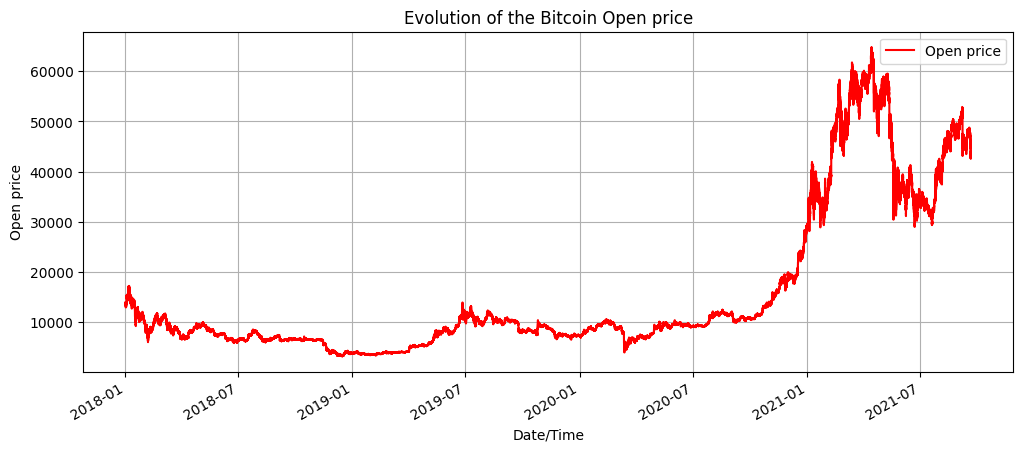

In [58]:
# Displaying a random dataframe (train)
_ = df_train[get_asset_id("Bitcoin")]["Open"].plot(label="Open price", color="red")
_ = plt.grid()
_ = plt.title("Evolution of the Bitcoin Open price")
_ = plt.legend()
_ = plt.xlabel("Date/Time")
_ = plt.ylabel("Open price")

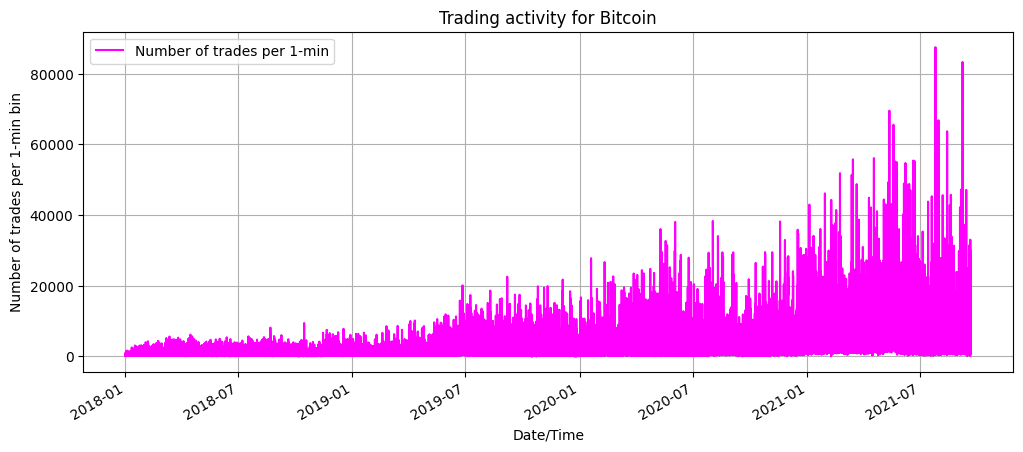

In [65]:
# Plotting trading activity
_ = df_train[get_asset_id("Bitcoin")][TRADING_ACTIVITY].plot(color="magenta")
_ = plt.grid()
_ = plt.title("Trading activity for Bitcoin")
_ = plt.legend(["Number of trades per 1-min"])
_ = plt.xlabel("Date/Time")
_ = plt.ylabel("Number of trades per 1-min bin")

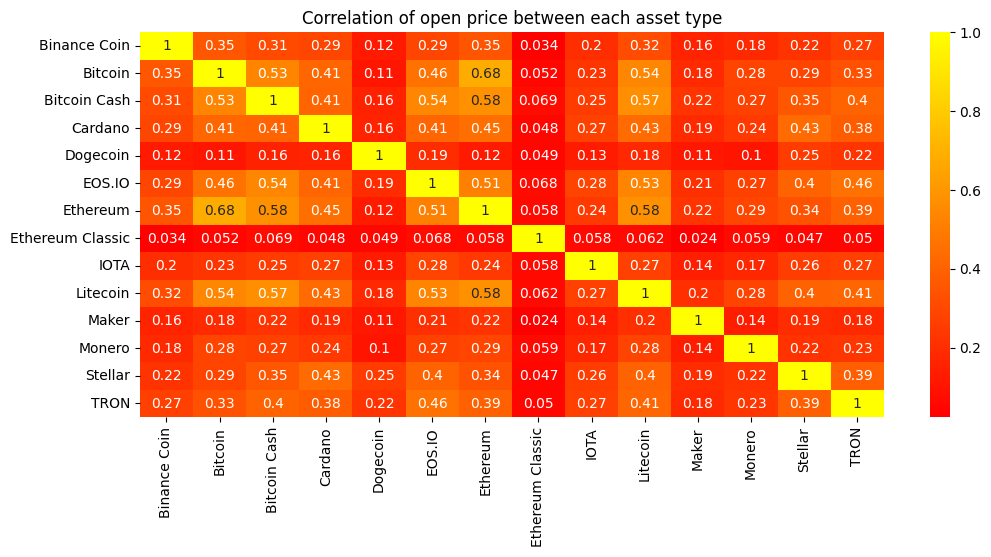

In [66]:
# Computing the correlation matrix of a given metric
X = pd.concat([df_train[k]["Volume"] for k in ASSET_IDS], axis=1)
X.columns = ASSET_NAMES

# Plot this correlation matrix
_ = sns.heatmap(X.corr(), annot=True, cmap="autumn")
_ = plt.title("Correlation of open price between each asset type")

In [36]:
# Plot candlestick representation
"""
s = mpf.make_mpf_style(base_mpf_style="yahoo", rc={'font.size': 10})
fig = mpf.figure(figsize=(20, 15), style=s)
ax = fig.add_subplot(2,1,1)
mpf.plot(df_train[4][OHLC][1:100], type="candle", ax=ax)
_ = plt.title("Candlestick representation for a tiny data sample")
_ = plt.xlabel("Date/Time")
"""

'\ns = mpf.make_mpf_style(base_mpf_style="yahoo", rc={\'font.size\': 10})\nfig = mpf.figure(figsize=(20, 15), style=s)\nax = fig.add_subplot(2,1,1)\nmpf.plot(df_train[4][OHLC][1:100], type="candle", ax=ax)\n_ = plt.title("Candlestick representation for a tiny data sample")\n_ = plt.xlabel("Date/Time")\n'

### NaN values & Other processing operations

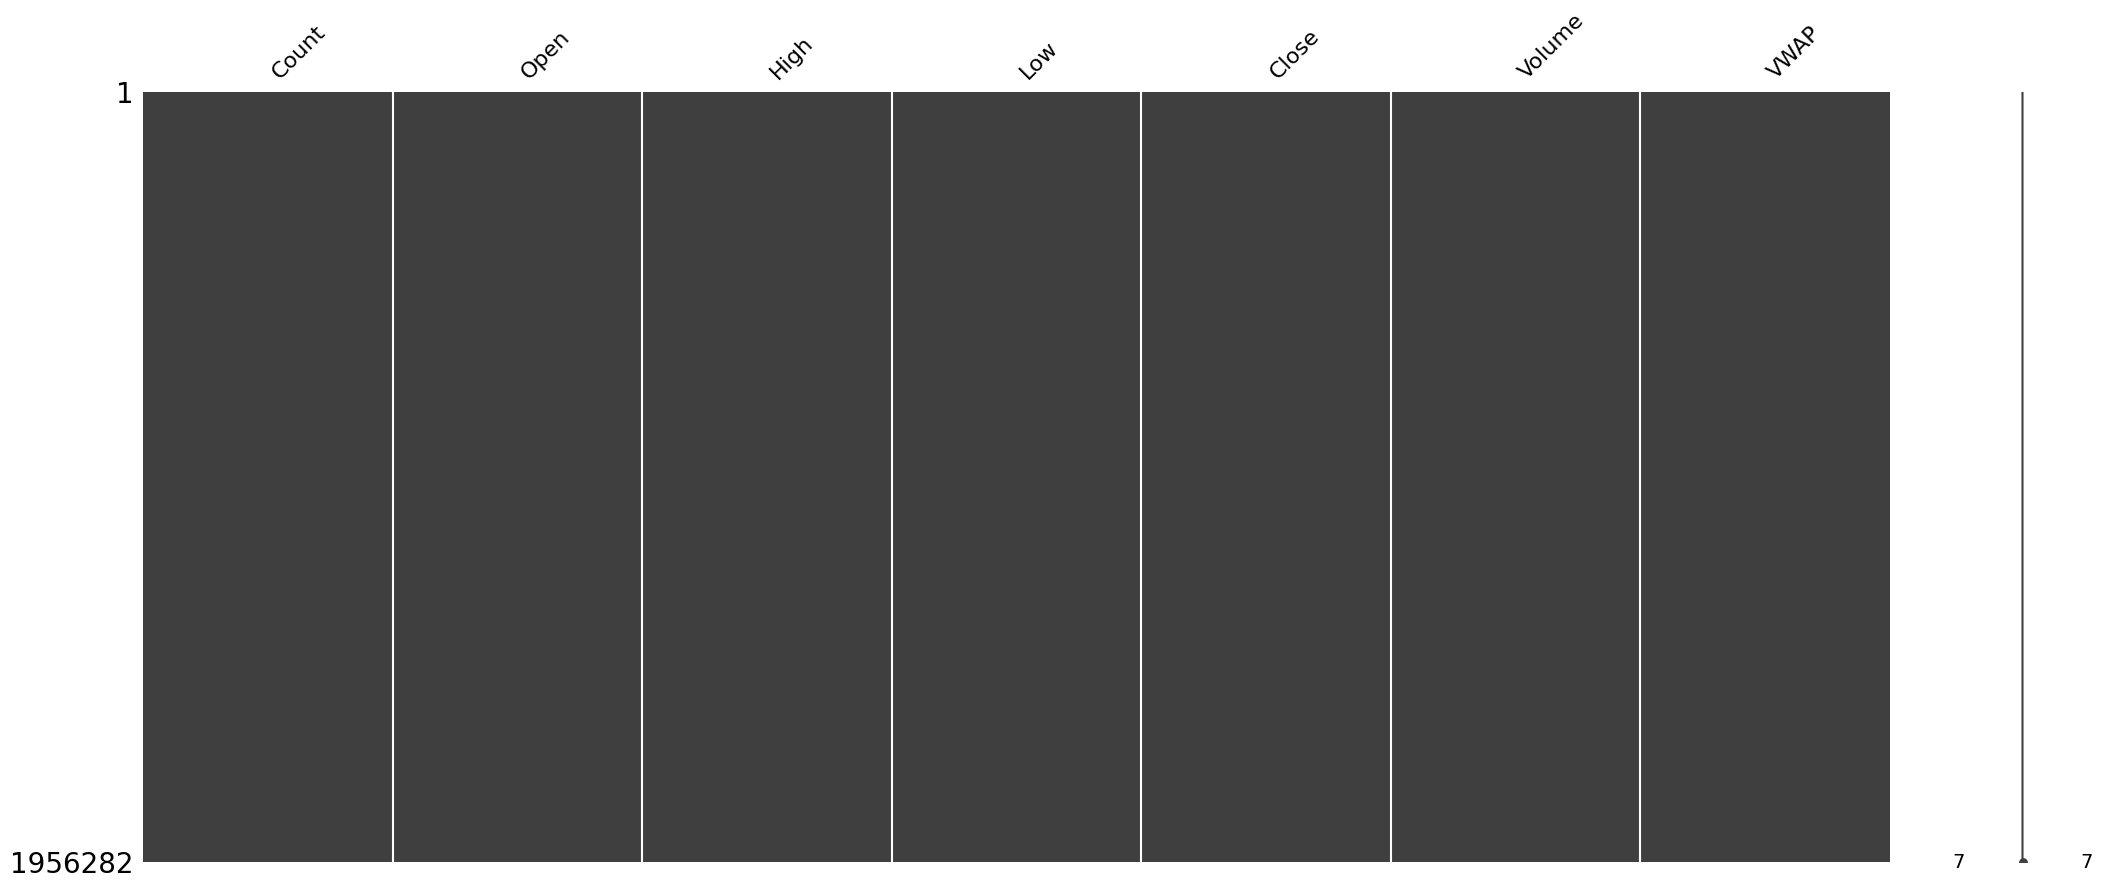

In [67]:
# Checking the NaN values distribution
_ = msn.matrix(df_train[get_asset_id("Bitcoin")])

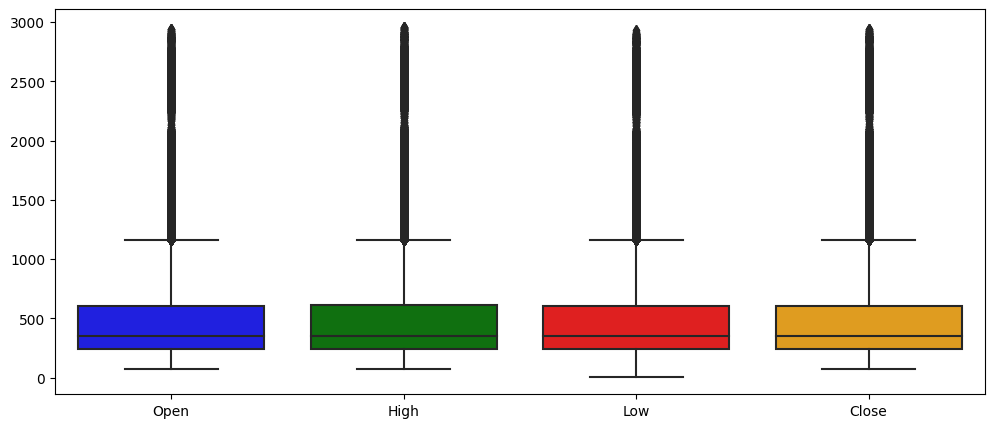

In [69]:
sns.boxplot(data=df_train[2][OHLC], showfliers=True);

## Trading strategies

## Conclusion

---

**Arian NAJAFY ABRANDABADY - Lucas RODRIGUEZ - Bastien TRIDON**